# v1 -> v2
- Uses self-created library for preprocessing
- Fixes many preprocessing errors
    - Now scales train/test sets properly
    - Removed custom mse function

## ETC

### `std_scale(data)`
- Arguments:
    - `data`, which is a numpy array of data
- Performs standard scaling

In [1]:
# we scale each sample relative to other samples
def std_scale(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return (data - mean) / stddev

# HRRR preprocessing

In [2]:
# define bounding box
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 40
frames_per_sample = 5

# date range of data
start_date, end_date = "2025-01-10-00", "2025-01-17-00"

In [3]:
from libs.hrrrdata import HRRRData
HD = HRRRData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    product='MASSDEN',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True
)

▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 00:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 01:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 02:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 03:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 04:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 05:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 06:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 07:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 08:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 09:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 10:00 UTC F00 ┊ source=aws
▌▌Herbie HRRR model sfc product initialized 2025-Jan-10 11:00 UTC F00 ┊ source=aws
▌▌He

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_03ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_64ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_10ef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_47ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_6def9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

In [4]:
X_hrrr = HD.data
print(X_hrrr.shape)

(164, 5, 40, 40, 1)


# AirNow preprocessing

In [5]:
from libs.airnowdata import AirNowData
AD = AirNowData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    airnow_api_key=None,
    save_dir='data/airnow.json',
    frames_per_sample=frames_per_sample,
    dim=dim
)

'data/airnow.json' already exists; skipping request...


In [6]:
X_airnow = AD.data
Y = AD.target_stations
print(X_airnow.shape)
print(Y.shape)

(164, 5, 40, 40, 1)
(164, 6)


# Joint preprocessing
- Create Y dataset
- Combine X datasets into 1 with 2 channels
- Split into train/test sets
- Scale train/test sets independently, and by channel

In [14]:
# for now we'll just scale first, as per the pwwb nb
X_hrrr = std_scale(X_hrrr)
X_airnow = std_scale(X_airnow)

# combine by adding a new channel
X = np.concatenate([X_hrrr, X_airnow], axis=-1)
print("HRRR and AirNow, combined by channel:", X.shape)

# perform a simple split into training and validation sets
split_idx = int(X.shape[0] * 0.75)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = Y[:split_idx], Y[split_idx:]

print("X_train/test dataset shape:", X_train.shape, X_test.shape)
print("y_train/test dataset shape:", y_train.shape, y_test.shape)

HRRR and AirNow, combined by channel: (164, 5, 40, 40, 2)
X_train/test dataset shape: (123, 5, 40, 40, 2) (41, 5, 40, 40, 2)
y_train/test dataset shape: (123, 6) (41, 6)


# Final input viz

Displaying frames for example 102.


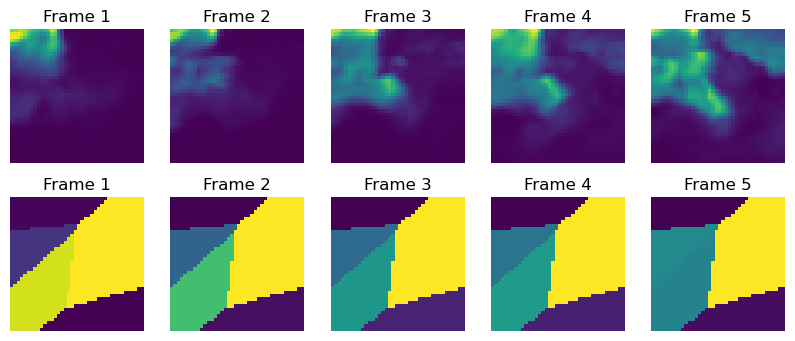

Target:  [ 2.  11.1 11.2 19.7  0.   4.8]


In [15]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
# plot hrrr channel
np.random.seed(42)
rand_sample = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
# plot airnow channel
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 1]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

# Model

In [16]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-08 23:03:20.862175: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 23:03:20.921736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 40, 40, 2))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(6,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        48,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,537 (463.04 KB)

 Trainable params: 118,537 (463.04 KB)

 Non-trainable params: 0 (0.00 B)

# Train and test

In [18]:
seq.fit(X_train, y_train, batch_size=16, epochs=150)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 12.4747
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 7.7754
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 7.4480
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 6.5258
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 6.1053
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 5.6427
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 5.4328
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 5.4580
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 5.5716
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 5.2820
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 6.1089
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 5.7651
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 4.7318
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 5.0847
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 4.4463
Epo

In [19]:
y_pred = seq.predict(X_test, verbose=0)
print(y_test.shape, y_pred.shape)

(41, 6) (41, 6)


In [20]:
from skimage.metrics import mean_squared_error as mse

def mserr(y_pred, y_test):
    ep = 0.45
    return ep + 0.002*mse(y_pred, y_test)

def rmse(y_pred, y_test):
    return np.sqrt(mserr(y_pred, y_test))

def nrmse(y_pred, y_test):
    return np.sqrt(mserr(y_pred, y_test)) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(airnow_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 0.70
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 7.27%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 0.69
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 5.70%

Frame 2 (Hour 2) All Locations - Raw RMSE: 0.68
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 5.91%

Frame 3 (Hour 3) All Locations - Raw RMSE: 0.69
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 5.69%

Frame 4 (Hour 4) All Locations - Raw RMSE: 0.70
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 5.64%

Frame 5 (Hour 5) All Locations - Raw

# Thoughts
- idk what `mserr` is doing, what's with this extra computation doing here? what not just basic `mse`?
- strictly speaking, I don't think we're "using the previous 5 frames to predict 5 future frames". We're using the 5 previous frames to predict the future values of the 6 stations in the next hour. It's not like a classic seq2seq model where 5 frames predict the next frame, then the next prediction uses 4+1 frames to predict the frame after, etc. To do that, we'll have to do next frame prediction (create a new hrrr frame and interpolated airnow sensor frame?

# RMSE results visualization


Visualizing model predictions vs actual values...


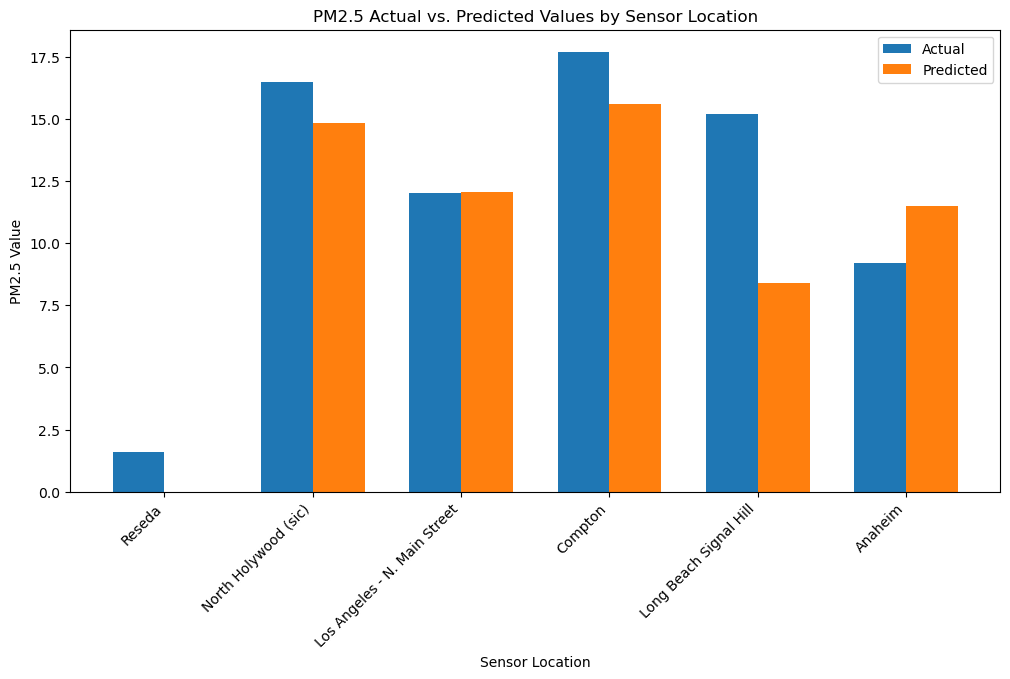

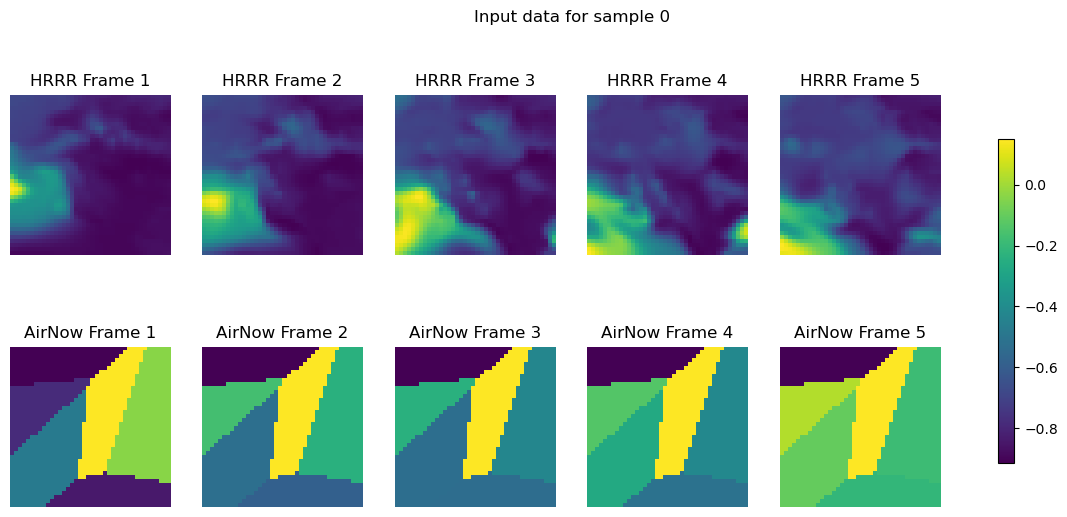

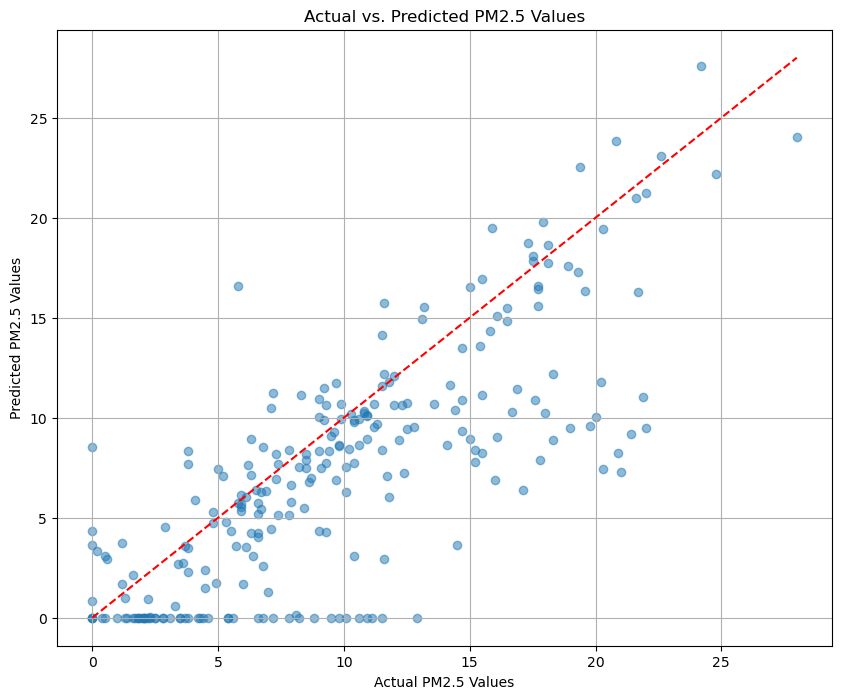

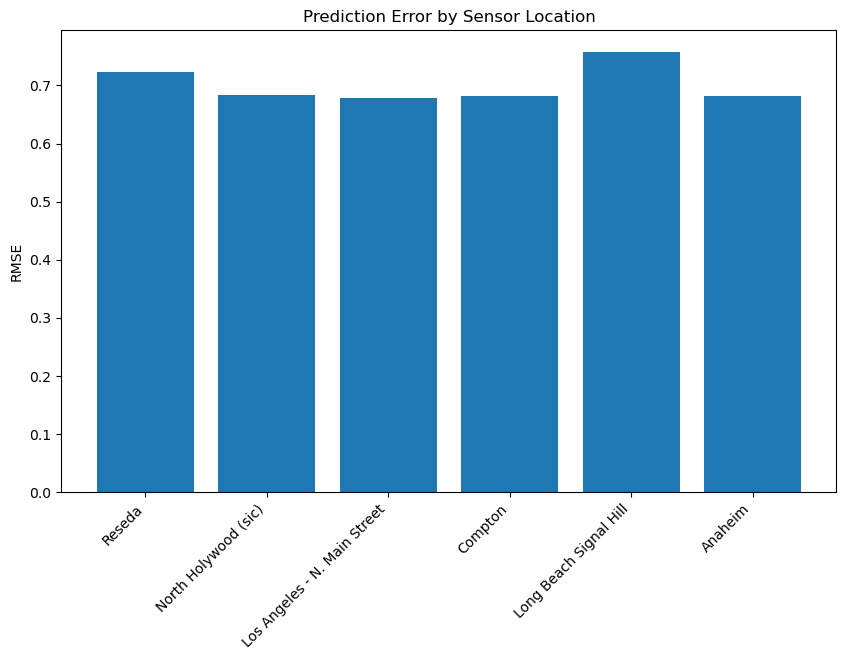

In [21]:
print("\nVisualizing model predictions vs actual values...")

# Choose the first test sample for consistent visualizations
sample_idx = 0

# Create a bar chart comparing predicted vs actual values for each sensor
fig, ax = plt.subplots(figsize=(12, 6))
sensor_names = list(airnow_sens_loc.keys())
x = np.arange(len(sensor_names))
width = 0.35

true_vals = y_test[sample_idx]
pred_vals = y_pred[sample_idx]

rects1 = ax.bar(x - width/2, true_vals, width, label='Actual')
rects2 = ax.bar(x + width/2, pred_vals, width, label='Predicted')

ax.set_title('PM2.5 Actual vs. Predicted Values by Sensor Location')
ax.set_ylabel('PM2.5 Value')
ax.set_xlabel('Sensor Location')
ax.set_xticks(x)
ax.set_xticklabels(sensor_names, rotation=45, ha='right')
ax.legend()

#plt.tight_layout()
plt.show()

# Visualize input data for a specific sample
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot hrrr data (channel 0)
for idx, ax in enumerate(axes[0]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 0]), cmap='viridis')
    ax.set_title(f"HRRR Frame {idx + 1}")
    ax.axis("off")

# Plot AirNow data (channel 1)
for idx, ax in enumerate(axes[1]):
    im = ax.imshow(np.squeeze(X_test[sample_idx, idx, :, :, 1]), cmap='viridis')
    ax.set_title(f"AirNow Frame {idx + 1}")
    ax.axis("off")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7)
plt.suptitle(f'Input data for sample {sample_idx}')
#plt.tight_layout()
plt.show()

# Create a scatter plot of predicted vs actual values
plt.figure(figsize=(10, 8))
plt.scatter(y_test.flatten(), y_pred.flatten(), alpha=0.5)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], 'r--')  # Perfect prediction line
plt.xlabel('Actual PM2.5 Values')
plt.ylabel('Predicted PM2.5 Values')
plt.title('Actual vs. Predicted PM2.5 Values')
plt.grid(True)
#plt.tight_layout()
plt.show()

# Compute error metrics for each sensor
error_by_sensor = []
for i, sensor in enumerate(sensor_names):
    error = rmse(y_pred[:, i], y_test[:, i])
    error_by_sensor.append(error)

# Create bar chart of errors by sensor
plt.figure(figsize=(10, 6))
plt.bar(sensor_names, error_by_sensor)
plt.ylabel('RMSE')
plt.title('Prediction Error by Sensor Location')
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()

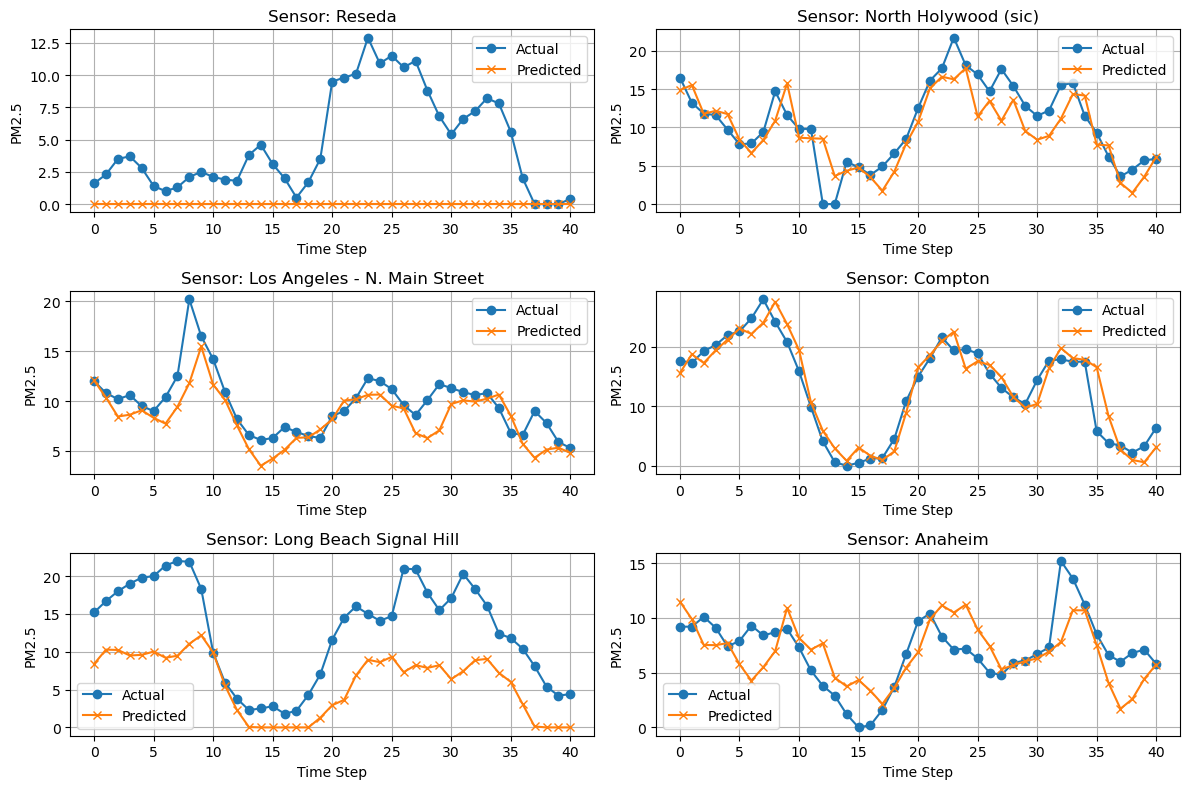

In [22]:
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(airnow_sens_loc.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()